In [1]:
import pandas as pd
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

In [2]:
# Importando o dataset
df = pd.read_parquet("data/conceito_igc_filtrado.parquet")

# Removendo IFEs que não possuam dados para todos os anos
df_ifes = df.groupby("sigla")["ano"].count().reset_index()
ifes_desconsiderar = df_ifes[df_ifes.ano < 3].sigla.to_list()

# Filtrando o dataset
df_tratado = df[~(df.sigla.isin(ifes_desconsiderar))]

# Indexando o dataset por sigla e ano (isto é, dividindo os dados em painel por entidade e tempo)
df_tratado = df_tratado.set_index(["sigla", "ano"])

In [3]:
# A variável a ser predita é o `conceito`, que corresponde ao CMG.
# As variáveis independentes são `taxa_desligamento` e `taxa_contratação`.
y = df_tratado[["conceito"]]
X = df_tratado[["taxa_desligamento", "taxa_contratacao"]]
X = sm.add_constant(X)

# Aplicando a regressão.
model = PanelOLS(y, X, entity_effects=True)
resultado = model.fit(cov_type="robust")
print(resultado)

                          PanelOLS Estimation Summary                           
Dep. Variable:               conceito   R-squared:                        0.2607
Estimator:                   PanelOLS   R-squared (Between):             -0.0515
No. Observations:                 156   R-squared (Within):               0.2607
Date:                Thu, May 29 2025   R-squared (Overall):             -0.0202
Time:                        10:15:09   Log-likelihood                    183.51
Cov. Estimator:                Robust                                           
                                        F-statistic:                      17.986
Entities:                          52   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                   F(2,102)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             17.628
                            

#### Verificando homocedasticidade

                            nome     valor
0  Lagrange multiplier statistic  3.488835
1                        p-value  0.174747
2                        f-value  1.750009
3                      f p-value  0.177233


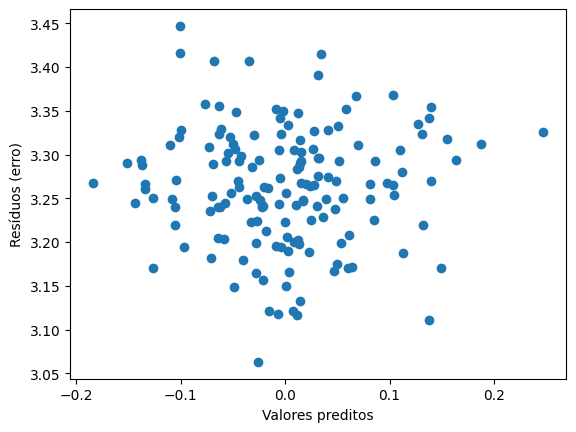

In [7]:
resid = resultado.resids.reset_index().residual.to_list()
res = sms.het_breuschpagan(resid, X)


# Plotando os dados para verificação visual
x = resid
y = resultado._fitted.reset_index().fitted_values.to_list()

names = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
print(pd.DataFrame({"nome": names, "valor": res}))

plt.scatter(x, y)
plt.ylabel("Resíduos (erro)")
plt.xlabel("Valores preditos")
plt.savefig("notas/output.png")